In [1]:
!date

Wed Sep 20 06:26:31 EDT 2023


In [3]:
%%time
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
cudnn.benchmark = True
plt.ion()   # interactive m
from datetime import datetime
now = datetime.now
T0 = now()

from IPython import display
import sys
import seaborn as sns
from IPython import display


CPU times: user 1.25 s, sys: 280 ms, total: 1.53 s
Wall time: 5.42 s


In [4]:
%%time
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 10.5 µs


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
def safe_mkdir(fn):
    import os
    if not os.path.exists(fn):
        os.mkdir(fn)

In [7]:
import sys
import psutil
def check_ram():
    try:
        ram_info = psutil.virtual_memory()
        print(f"Total: {ram_info.total / 1024 / 1024 / 1024:.2f} GB")
        print(f"Available: {ram_info.available / 1024 / 1024 / 1024:.2f} GB")
        print(f"Used: {ram_info.used / 1024 / 1024 / 1024:.2f} GB")
        print(f"Percentage usage: {ram_info.percent}%")
    except FileNotFoundError:
        print("Ram info not available on this system")

In [8]:
dataset_path = './Data/pytorch-data/xl_121_15_action_data_orig'

cats = os.listdir(os.path.join(dataset_path,'train'))
cats.sort()
cats = np.array(cats)

n_cats = len(cats)
n_cats

121

In [ ]:
indir = os.path.join(dataset_path,'val')
folders = os.listdir(indir)
folders.sort()
folders = np.array(folders)
folder_files = []

files = [os.path.join(indir,folders[0],file) for file in os.listdir(os.path.join(indir,folders[0])) if file.endswith('.jpg')]
files.sort()
folder_files = np.array(files)
for folder in folders[1::]:
    files = [os.path.join(indir,folder,file) for file in os.listdir(os.path.join(indir,folder)) if file.endswith('.jpg')]
    files.sort()
    folder_files = np.hstack((folder_files,files))

frames_lbls_vec_val = np.array([np.argwhere(cats==f.split('/')[-2])[0][0] for f in folder_files])
print(folder_files.shape)
folder_files[0:5]

In [ ]:
indir = os.path.join(dataset_path,'train')
folders = os.listdir(indir)
folders.sort()
folders = np.array(folders)
folder_files = []

files = [os.path.join(indir,folders[0],file) for file in os.listdir(os.path.join(indir,folders[0])) if file.endswith('.jpg')]
files.sort()
folder_files = np.array(files)
for folder in folders[1::]:
    files = [os.path.join(indir,folder,file) for file in os.listdir(os.path.join(indir,folder)) if file.endswith('.jpg')]
    files.sort()
    folder_files = np.hstack((folder_files,files))

frames_lbls_vec = np.array([np.argwhere(cats==f.split('/')[-2])[0][0] for f in folder_files])
print(folder_files.shape)
folder_files[0:5]

In [11]:
def divide_chunks(l, n):
    # Yield successive n-sized
    # chunks from l.
    # looping till length l
    for i in range(0, len(l), n): 
        yield l[i:i + n]

## LOAD DATA

In [13]:
%%time
val_data_flows_bg = np.load('./Data/pytorch-data/flows2/flows3-bg-val-flows.npy')
val_labels_flows_bg = np.load('./Data/pytorch-data/flows2/flows3-bg-val-labels.npy').astype(int)

val_data_flows_seg = np.load('./Data/pytorch-data/flows2/flows3-seg-val-flows.npy')
val_labels_flows_seg = np.load('./Data/pytorch-data/flows2/flows3-seg-val-labels.npy').astype(int)

val_data_frames_bg = np.load('./Data/pytorch-data/DomainNet-frames-bg-6936-val.npy')
val_data_frames_seg = np.load('./Data/pytorch-data/DomainNet-frames-seg-6936-val.npy')

print(val_data_flows_bg.shape)
print(val_labels_flows_bg.shape)
print(val_data_flows_seg.shape)
print(val_labels_flows_seg.shape)
print(val_data_frames_bg.shape)
print(val_data_frames_seg.shape)

(6300, 2, 224, 224)
(6300,)
(6300, 2, 224, 224)
(6300,)
(6936, 3, 224, 224)
(6936, 3, 224, 224)
CPU times: user 0 ns, sys: 2.03 s, total: 2.03 s
Wall time: 4.26 s


In [14]:
%%time
training_data_flows_bg = np.load('./Data/pytorch-data/flows2/flows3-bg-train-flows.npy')
training_labels_flows_bg = np.load('./Data/pytorch-data/flows2/flows3-bg-train-labels.npy').astype(int)

training_data_flows_seg = np.load('./Data/pytorch-data/flows2/flows3-seg-train-flows.npy')
training_labels_flows_seg = np.load('./Data/pytorch-data/flows2/flows3-seg-train-labels.npy').astype(int)

training_data_frames_bg = np.load('./Data/pytorch-data/DomainNet-frames-bgg-95056.npy')
training_data_frames_seg = np.load('./Data/pytorch-data/DomainNet-frames-seg-95056.npy')


print(training_data_flows_bg.shape)
print(training_labels_flows_bg.shape)
print(training_data_flows_seg.shape)
print(training_labels_flows_seg.shape)
print(training_data_frames_bg.shape)
print(training_data_frames_seg.shape)

(86410, 2, 224, 224)
(86410,)
(86410, 2, 224, 224)
(86410,)
(95056, 3, 224, 224)
(95056, 3, 224, 224)
CPU times: user 0 ns, sys: 31 s, total: 31 s
Wall time: 50.8 s


## END LOAD DATA

In [15]:
frame_chunks = list(divide_chunks(folder_files, 11))
idx_chunks_frames = list(divide_chunks(np.arange(training_data_frames_bg.shape[0]), 11))
idx_chunks_flows = list(divide_chunks(np.arange(training_data_flows_bg.shape[0]), 10))
lbls_chunks = list(divide_chunks(frames_lbls_vec, 11))

In [17]:
def get_batch(batch_size = 32):
    
    choose_cat = np.random.randint(low=0,high=120,size=batch_size)
    
    frames_idx = np.array([np.random.permutation(np.nonzero(frames_lbls_vec==c)[0])[0] for c in choose_cat])
    flows_idx = np.floor((frames_idx/11*10)).astype(int)
    
    lbls_frames = frames_lbls_vec[frames_idx]
    lbls_flows = training_labels_flows_seg[flows_idx]
    
    batch_frames_bg = training_data_frames_bg[frames_idx,:,:,:]
    batch_frames_seg = training_data_frames_seg[frames_idx,:,:,:]
    batch_flows_bg = training_data_flows_bg[flows_idx,:,:,:]
    batch_flows_seg = training_data_flows_seg[flows_idx,:,:,:]

    return {'lbls_frames' : lbls_frames,
            'lbls_flows' : lbls_flows,
            'batch_frames_bg' : batch_frames_bg,
            'batch_frames_seg' : batch_frames_seg,
            'batch_flows_bg' : batch_flows_bg,
            'batch_flows_seg' : batch_flows_seg}

In [18]:
def get_batch_val(batch_size = 32):
    
    choose_cat = np.random.randint(low=0,high=120,size=batch_size)
    
    frames_idx = np.array([np.random.permutation(np.nonzero(frames_lbls_vec_val==c)[0])[0] for c in choose_cat])
    flows_idx = np.floor((frames_idx/11*10)).astype(int)
    
    
    lbls_frames = frames_lbls_vec_val[frames_idx]
    lbls_flows = val_labels_flows_seg[flows_idx]
    
    batch_frames_bg = val_data_frames_bg[frames_idx,:,:,:]
    batch_frames_seg = val_data_frames_seg[frames_idx,:,:,:]
    batch_flows_bg = val_data_flows_bg[flows_idx,:,:,:]
    batch_flows_seg = val_data_flows_seg[flows_idx,:,:,:]

    return {'lbls_frames' : lbls_frames,
            'lbls_flows' : lbls_flows,
            'batch_frames_bg' : batch_frames_bg,
            'batch_frames_seg' : batch_frames_seg,
            'batch_flows_bg' : batch_flows_bg,
            'batch_flows_seg' : batch_flows_seg}

In [19]:
batch = get_batch()
[batch[key].shape for key in list(batch.keys())]

[(32,),
 (32,),
 (32, 3, 224, 224),
 (32, 3, 224, 224),
 (32, 2, 224, 224),
 (32, 2, 224, 224)]

Text(0.5, 0.92, 'fish-hunting_hold')

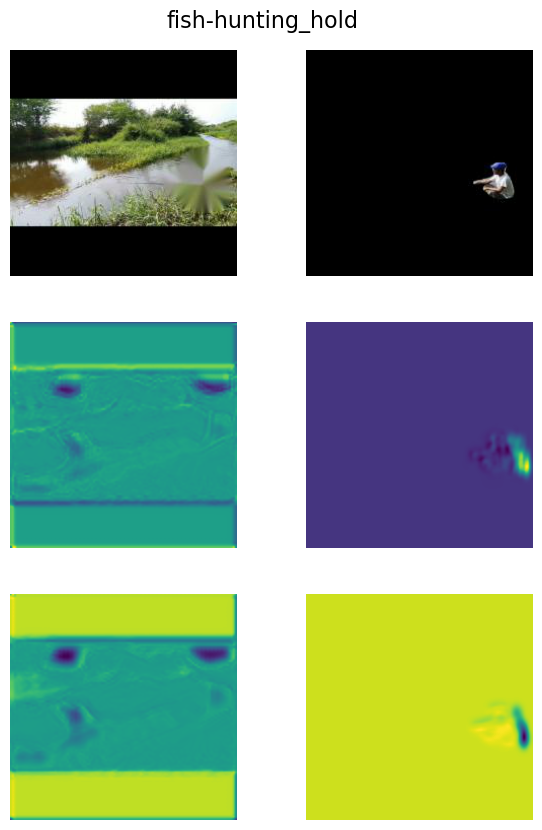

In [21]:
batch = get_batch()
batch.keys()

plt.figure(figsize=(7,10))
plt.subplot(3,2,1);plt.imshow(batch['batch_frames_bg'][0,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float));plt.axis('off')
plt.subplot(3,2,2);plt.imshow(batch['batch_frames_seg'][0,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float));plt.axis('off')
plt.subplot(3,2,3);plt.imshow(batch['batch_flows_bg'][0,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float)[:,:,0] );plt.axis('off')
plt.subplot(3,2,4);plt.imshow(batch['batch_flows_seg'][0,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float)[:,:,0] );plt.axis('off')
plt.subplot(3,2,5);plt.imshow(batch['batch_flows_bg'][0,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float)[:,:,1] );plt.axis('off')
plt.subplot(3,2,6);plt.imshow(batch['batch_flows_seg'][0,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float)[:,:,1] );plt.axis('off')
plt.suptitle(cats[batch['lbls_frames'][0]],y=.92,fontsize=16)

Text(0.5, 0.92, 'gym_squat')

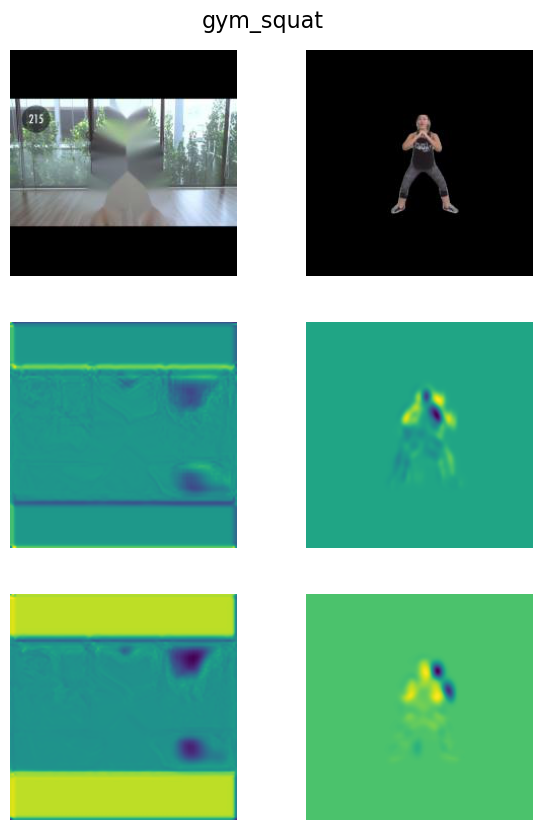

In [22]:
batch = get_batch_val()
batch.keys()

plt.figure(figsize=(7,10))
plt.subplot(3,2,1);plt.imshow(batch['batch_frames_bg'][0,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float));plt.axis('off')
plt.subplot(3,2,2);plt.imshow(batch['batch_frames_seg'][0,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float));plt.axis('off')
plt.subplot(3,2,3);plt.imshow(batch['batch_flows_bg'][0,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float)[:,:,0] );plt.axis('off')
plt.subplot(3,2,4);plt.imshow(batch['batch_flows_seg'][0,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float)[:,:,0] );plt.axis('off')
plt.subplot(3,2,5);plt.imshow(batch['batch_flows_bg'][0,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float)[:,:,1] );plt.axis('off')
plt.subplot(3,2,6);plt.imshow(batch['batch_flows_seg'][0,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float)[:,:,1] );plt.axis('off')
plt.suptitle(cats[batch['lbls_frames'][0]],y=.92,fontsize=16)

In [24]:
staticNet_BG = resnet50()
staticNet_BG.fc = nn.Linear(staticNet_BG.fc.in_features,n_cats)

staticNet_BG.half();
staticNet_BG = staticNet_BG.to(device)

In [25]:
staticNet_SEG = resnet50()
staticNet_SEG.fc = nn.Linear(staticNet_SEG.fc.in_features,n_cats)

staticNet_SEG.half();
staticNet_SEG = staticNet_SEG.to(device)

In [26]:
flowNet_BG = resnet50()
flowNet_BG.fc = nn.Linear(flowNet_BG.fc.in_features,n_cats)
flowNet_BG.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)

flowNet_BG.half();
flowNet_BG = flowNet_BG.to(device)

In [27]:
flowNet_SEG = resnet50()
flowNet_SEG.fc = nn.Linear(flowNet_SEG.fc.in_features,n_cats)
flowNet_SEG.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)

flowNet_SEG.half();
flowNet_SEG = flowNet_SEG.to(device)

In [28]:
class CombinedNet(nn.Module):

    def __init__(self,staticNet_BG,staticNet_SEG,flowNet_BG,flowNet_SEG):
        super(CombinedNet, self).__init__()
        self.staticNet_BG = staticNet_BG
        self.staticNet_SEG = staticNet_SEG
        self.flowNet_BG = flowNet_BG
        self.flowNet_SEG = flowNet_SEG

    def forward(self,batch_frames_bg,batch_frames_seg,batch_flows_bg,batch_flows_seg):

        out_frames_bg = self.staticNet_BG( batch_frames_bg )
        out_frames_seg = self.staticNet_SEG( batch_frames_seg )
        out_flows_bg = self.flowNet_BG( batch_flows_bg )
        out_flows_seg = self.flowNet_SEG( batch_flows_seg )
        
        out_combined = out_frames_bg+out_frames_seg+out_flows_bg+out_flows_seg

        return out_frames_bg,out_frames_seg,out_flows_bg,out_flows_seg,out_combined

In [29]:
## COMBnet
combinedNet = CombinedNet(staticNet_BG,staticNet_SEG,flowNet_BG,flowNet_SEG)

combinedNet.half()
combinedNet.to(device)

criterion = nn.CrossEntropyLoss()                                 # specify the loss function
optimizer = optim.SGD(combinedNet.parameters(), lr=0.001, momentum=0.9)     # specify the optimizer

In [30]:
save_dir = './Data/pytorch-data/weights/DomainNet_4stream-4-withVal'
safe_mkdir(save_dir)

In [31]:
loss_frames_bg = []
loss_frames_seg = []
loss_flows_bg = []
loss_flows_seg = []
loss_comb = []
loss_total = []

acc_train_frames_bg = []
acc_train_frames_seg = []
acc_train_flows_bg = []
acc_train_flows_seg = []
acc_train_comb = []

In [32]:
val_loss_frames_bg = []
val_loss_frames_seg = []
val_loss_flows_bg = []
val_loss_flows_seg = []
val_loss_comb = []
val_loss_total = []

acc_val_frames_bg = []
acc_val_frames_seg = []
acc_val_flows_bg = []
acc_val_flows_seg = []
acc_val_comb = []

In [33]:
def do_validation_step():
    combinedNet.eval();
    
    val_chunk_size = 34
    val_chunks = list(divide_chunks(frames_lbls_vec_val,val_chunk_size))
    
    temp_val_top5_acc_frames_bg = 0
    temp_val_top5_acc_frames_seg = 0
    temp_val_top5_acc_flows_bg = 0
    temp_val_top5_acc_flows_seg = 0
    temp_val_top5_acc_combined = 0
    
    temp_val_loss_frames_bg = 0
    temp_val_loss_frames_seg = 0
    temp_val_loss_flows_bg = 0
    temp_val_loss_flows_seg = 0
    temp_val_loss_combined = 0
    temp_val_loss_total = 0
    
    for v in range(len(val_chunks)):
    
        frames_idx = val_chunks[v]
        flows_idx = np.floor((frames_idx/11*10)).astype(int)
        
        lbls_frames = frames_lbls_vec_val[frames_idx]
        lbls_flows = val_labels_flows_seg[flows_idx]
        
        batch_frames_bg = val_data_frames_bg[frames_idx,:,:,:]
        batch_frames_seg = val_data_frames_seg[frames_idx,:,:,:]
        batch_flows_bg = val_data_flows_bg[flows_idx,:,:,:]
        batch_flows_seg = val_data_flows_seg[flows_idx,:,:,:]
        
        batch_lbls = torch.from_numpy(lbls_flows).long()
        batch_frames_bg = torch.from_numpy(batch_frames_bg).half()
        batch_frames_seg = torch.from_numpy(batch_frames_seg).half()
        batch_flows_bg = torch.from_numpy(batch_flows_bg).half()
        batch_flows_seg = torch.from_numpy(batch_flows_seg).half()
        
        batch_lbls = batch_lbls.cuda()
        batch_frames_bg = batch_frames_bg.cuda()
        batch_frames_seg = batch_frames_seg.cuda()
        batch_flows_bg = batch_flows_bg.cuda()
        batch_flows_seg = batch_flows_seg.cuda()
        
        out_frames_bg,out_frames_seg,out_flows_bg,out_flows_seg,out_combined = combinedNet(batch_frames_bg,batch_frames_seg,batch_flows_bg,batch_flows_seg)
        
        temp_val_top5_acc_frames_bg += np.array([lbls_frames[i] in np.argsort(out_frames_bg.detach().cpu().numpy()[i,:])[-1::-1][0:5] for i in range(len(lbls_frames))]).mean()
        temp_val_top5_acc_frames_seg += np.array([lbls_frames[i] in np.argsort(out_frames_seg.detach().cpu().numpy()[i,:])[-1::-1][0:5] for i in range(len(lbls_frames))]).mean()
        temp_val_top5_acc_flows_bg += np.array([lbls_frames[i] in np.argsort(out_flows_bg.detach().cpu().numpy()[i,:])[-1::-1][0:5] for i in range(len(lbls_frames))]).mean()
        temp_val_top5_acc_flows_seg += np.array([lbls_frames[i] in np.argsort(out_flows_seg.detach().cpu().numpy()[i,:])[-1::-1][0:5] for i in range(len(lbls_frames))]).mean()
        temp_val_top5_acc_combined += np.array([lbls_frames[i] in np.argsort(out_combined.detach().cpu().numpy()[i,:])[-1::-1][0:5] for i in range(len(lbls_frames))]).mean()
        
        temp_val_loss_frames_bg += criterion(out_frames_bg, batch_lbls).data.item() 
        temp_val_loss_frames_seg += criterion(out_frames_seg, batch_lbls).data.item() 
        temp_val_loss_flows_bg += criterion(out_flows_bg, batch_lbls).data.item() 
        temp_val_loss_flows_seg += criterion(out_flows_seg, batch_lbls).data.item() 
        temp_val_loss_combined += criterion(out_combined, batch_lbls).data.item() 
        temp_val_loss_total += temp_val_loss_frames_bg+temp_val_loss_frames_seg+temp_val_loss_flows_bg+temp_val_loss_flows_seg+temp_val_loss_combined
    
    val_loss_frames_bg.append( temp_val_loss_frames_bg/v )
    val_loss_frames_seg.append( temp_val_loss_frames_seg/v )
    val_loss_flows_bg.append( temp_val_loss_flows_bg/v )
    val_loss_flows_seg.append( temp_val_loss_flows_seg/v )
    val_loss_comb.append( temp_val_loss_combined/v )
    val_loss_total.append( temp_val_loss_total/v )
    
    acc_val_frames_bg.append( temp_val_top5_acc_frames_bg/v )
    acc_val_frames_seg.append( temp_val_top5_acc_frames_seg/v )
    acc_val_flows_bg.append( temp_val_top5_acc_flows_bg/v )
    acc_val_flows_seg.append( temp_val_top5_acc_flows_seg/v )
    acc_val_comb.append( temp_val_top5_acc_combined/v )

    combinedNet.train();

In [34]:
def dashboard():

    if np.mod(epoch,5)==0:
        plt.close()

        
    from IPython import display
    import sys


    display.clear_output(wait=True);
    display.display(plt.gcf());

    
    nrows=4
    ncols = 6
    c = 0
    plt.figure(figsize=(20,10))
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot(loss_frames_bg);plt.title('loss_frames_bg')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot(loss_frames_seg);plt.title('loss_frames_seg')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot(loss_flows_bg);plt.title('loss_flows_bg')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot(loss_flows_seg);plt.title('loss_flows_seg')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot(loss_comb);plt.title('loss_comb')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot(loss_total);plt.title('loss_total')
    
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot(acc_train_frames_bg);plt.title('acc_train_frames_bg')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot(acc_train_frames_seg);plt.title('acc_train_frames_seg')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot(acc_train_flows_bg);plt.title('acc_train_flows_bg')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot(acc_train_flows_seg);plt.title('acc_train_flows_seg')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot(acc_train_comb);plt.title('acc_train_comb');c = c+1;


    c = c+1;plt.subplot(nrows,ncols,c);plt.plot( val_loss_frames_bg );plt.title('val_loss_frames_bg')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot( val_loss_frames_seg );plt.title('val_loss_frames_seg')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot( val_loss_flows_bg );plt.title('val_loss_flows_bg')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot( val_loss_flows_seg );plt.title('val_loss_flows_seg')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot( val_loss_comb );plt.title('val_loss_comb')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot( val_loss_total );plt.title('val_loss_total')

    c = c+1;plt.subplot(nrows,ncols,c);plt.plot( acc_val_frames_bg );plt.title('acc_val_frames_bg')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot( acc_val_frames_seg );plt.title('acc_val_frames_seg')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot( acc_val_flows_bg );plt.title('acc_val_flows_bg')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot( acc_val_flows_seg );plt.title('acc_val_flows_seg')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot( acc_val_comb );plt.title('acc_val_comb')

    plt.suptitle(f' epoch {epoch}, T elapsed = {now()-t00}')
    
    plt.tight_layout()
    plt.show()

    sys.stdout.flush()

In [35]:
do_train = False

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

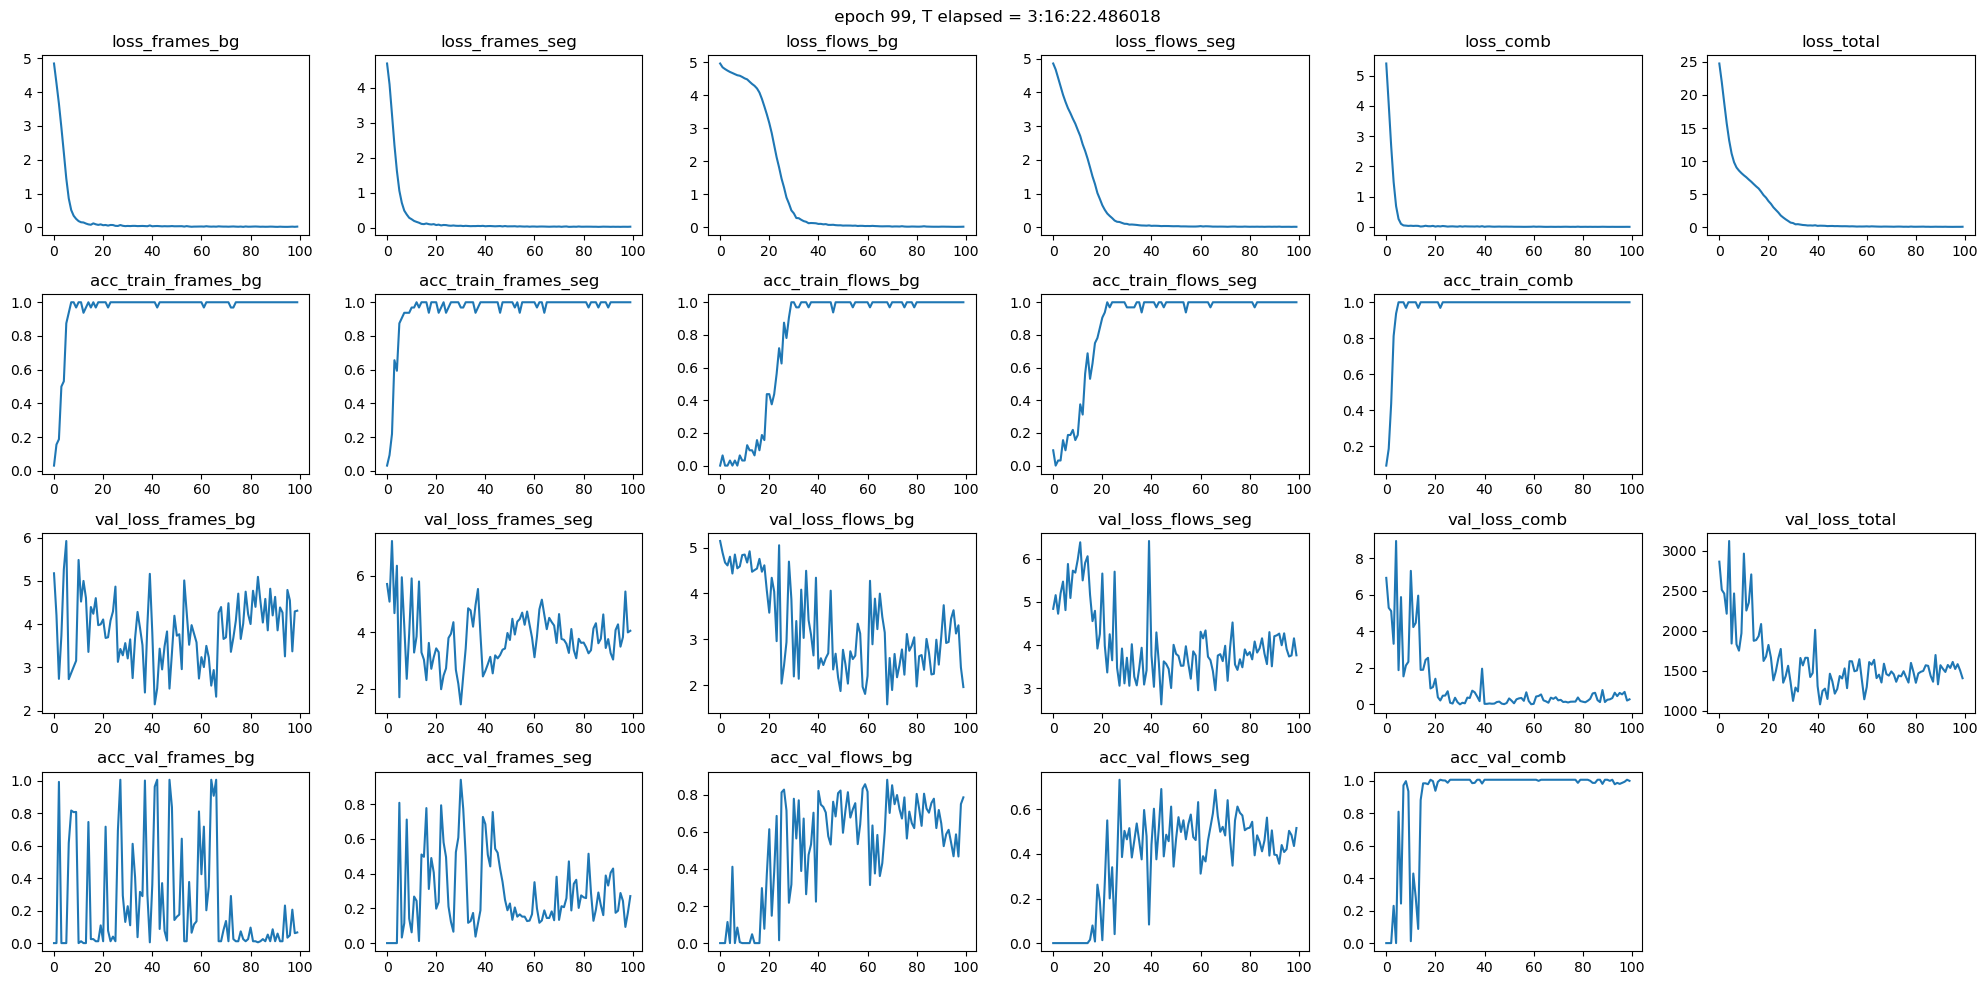

100%|██████████████████████████████████████| 100/100 [3:16:23<00:00, 117.84s/it]


In [36]:
if do_train==True:
    t00 = now()
    for epoch in tqdm( range(100) ):
        
        epoch_loss_frames_bg = 0
        epoch_loss_frames_seg = 0
        epoch_loss_flows_bg = 0
        epoch_loss_flows_seg = 0
        epoch_loss_comb = 0
        epoch_loss_total = 0
        
        combinedNet.train()
        for b in range(500):
        
            optimizer.zero_grad();

            batch = get_batch()
            
            batch_lbls = torch.from_numpy(batch['lbls_flows']).long()
            batch_frames_bg = torch.from_numpy(batch['batch_frames_bg']).half()
            batch_frames_seg = torch.from_numpy(batch['batch_frames_seg']).half()
            batch_flows_bg = torch.from_numpy(batch['batch_flows_bg']).half()
            batch_flows_seg = torch.from_numpy(batch['batch_flows_seg']).half()
    
    
            batch_lbls = batch_lbls.cuda()
            batch_frames_bg = batch_frames_bg.cuda()
            batch_frames_seg = batch_frames_seg.cuda()
            batch_flows_bg = batch_flows_bg.cuda()
            batch_flows_seg = batch_flows_seg.cuda()

           
            out_frames_bg,out_frames_seg,out_flows_bg,out_flows_seg,out_combined = combinedNet(batch_frames_bg,batch_frames_seg,batch_flows_bg,batch_flows_seg)
            
            
            batch_loss_frames_bg = criterion(out_frames_bg, batch_lbls)
            epoch_loss_frames_bg+=batch_loss_frames_bg.data.item() 
    
            batch_loss_frames_seg = criterion(out_frames_seg, batch_lbls)
            epoch_loss_frames_seg+=batch_loss_frames_seg.data.item() 
    
            batch_loss_flows_bg = criterion(out_flows_bg, batch_lbls)
            epoch_loss_flows_bg+=batch_loss_flows_bg.data.item() 
    
            batch_loss_flows_seg = criterion(out_flows_seg, batch_lbls)
            epoch_loss_flows_seg+=batch_loss_flows_seg.data.item() 
    
            batch_loss_comb = criterion(out_combined, batch_lbls)
            epoch_loss_comb+=batch_loss_comb.data.item() 
    
            total_loss = batch_loss_frames_bg+batch_loss_frames_seg+batch_loss_flows_bg+batch_loss_flows_seg+batch_loss_comb
            epoch_loss_total+=total_loss.data.item() 
            
            assert not np.isnan(epoch_loss_total), 'loss is NaN'
            
            total_loss.backward()
            optimizer.step()
    
        # Collect data end of each epoch
        loss_frames_bg.append( epoch_loss_frames_bg/b )
        loss_frames_seg.append( epoch_loss_frames_seg/b )
        loss_flows_bg.append( epoch_loss_flows_bg/b )
        loss_flows_seg.append( epoch_loss_flows_seg/b )
        loss_comb.append( epoch_loss_comb/b )
        loss_total.append( epoch_loss_total/b )
    
        acc_train_frames_bg.append( (out_frames_bg.detach().cpu().numpy().argmax(axis=1)==batch_lbls.detach().cpu().numpy()).mean() )
        acc_train_frames_seg.append( (out_frames_seg.detach().cpu().numpy().argmax(axis=1)==batch_lbls.detach().cpu().numpy()).mean() )
        acc_train_flows_bg.append( (out_flows_bg.detach().cpu().numpy().argmax(axis=1)==batch_lbls.detach().cpu().numpy()).mean() )
        acc_train_flows_seg.append( (out_flows_seg.detach().cpu().numpy().argmax(axis=1)==batch_lbls.detach().cpu().numpy()).mean() )
        acc_train_comb.append( (out_combined.detach().cpu().numpy().argmax(axis=1)==batch_lbls.detach().cpu().numpy()).mean() )


        
        do_validation_step()
        
        dashboard()


In [ ]:
if do_train == True:
    torch.save(combinedNet.state_dict(), os.path.join(save_dir,'weights'))
    np.save(os.path.join(save_dir,'loss_frames_bg.npy'),loss_frames_bg)
    np.save(os.path.join(save_dir,'loss_frames_seg.npy'),loss_frames_seg)
    np.save(os.path.join(save_dir,'loss_flows_bg.npy'),loss_flows_bg)
    np.save(os.path.join(save_dir,'loss_flows_seg.npy'),loss_flows_seg)
    np.save(os.path.join(save_dir,'loss_comb.npy'),loss_comb)
    np.save(os.path.join(save_dir,'loss_total.npy'),loss_total)
    np.save(os.path.join(save_dir,'acc_train_frames_bg.npy'),acc_train_frames_bg)
    np.save(os.path.join(save_dir,'acc_train_frames_seg.npy'),acc_train_frames_seg)
    np.save(os.path.join(save_dir,'acc_train_flows_bg.npy'),acc_train_flows_bg)
    np.save(os.path.join(save_dir,'acc_train_flows_seg.npy'),acc_train_flows_seg)
    np.save(os.path.join(save_dir,'acc_train_comb.npy'),acc_train_comb)
else:
    epoch = 0
    t00 = now()
    loss_frames_bg = np.load(os.path.join(save_dir,'loss_frames_bg.npy'))
    loss_frames_seg = np.load(os.path.join(save_dir,'loss_frames_seg.npy'))
    loss_flows_bg = np.load(os.path.join(save_dir,'loss_flows_bg.npy'))
    loss_flows_seg = np.load(os.path.join(save_dir,'loss_flows_seg.npy'))
    loss_comb = np.load(os.path.join(save_dir,'loss_comb.npy'))
    loss_total = np.load(os.path.join(save_dir,'loss_total.npy'))
    acc_train_frames_bg = np.load(os.path.join(save_dir,'acc_train_frames_bg.npy'))
    acc_train_frames_seg = np.load(os.path.join(save_dir,'acc_train_frames_seg.npy'))
    acc_train_flows_bg = np.load(os.path.join(save_dir,'acc_train_flows_bg.npy'))
    acc_train_flows_seg = np.load(os.path.join(save_dir,'acc_train_flows_seg.npy'))
    acc_train_comb = np.load(os.path.join(save_dir,'acc_train_comb.npy'))

    combinedNet.load_state_dict(torch.load(save_dir+'/weights'))

dashboard()

In [37]:
combinedNet.eval();

In [38]:
del training_data_flows_bg
del training_labels_flows_bg

del training_data_flows_seg
del training_labels_flows_seg

del training_data_frames_bg
del training_data_frames_seg

In [40]:
indir = os.path.join(dataset_path,'test')
folders = os.listdir(indir)
folders.sort()
folders = np.array(folders)
folder_files = []

files = [os.path.join(indir,folders[0],file) for file in os.listdir(os.path.join(indir,folders[0])) if file.endswith('.jpg')]
files.sort()
folder_files = np.array(files)
for folder in folders[1::]:
    files = [os.path.join(indir,folder,file) for file in os.listdir(os.path.join(indir,folder)) if file.endswith('.jpg')]
    files.sort()
    folder_files = np.hstack((folder_files,files))

frames_lbls_vec = np.array([np.argwhere(cats==f.split('/')[-2])[0][0] for f in folder_files])
print(folder_files.shape)
folder_files[0:5]

(7697,)


array(['./Data/pytorch-data/xl_121_15_action_data_orig/test/add_new_car_tire/001_000.jpg',
       './Data/pytorch-data/xl_121_15_action_data_orig/test/add_new_car_tire/001_001.jpg',
       './Data/pytorch-data/xl_121_15_action_data_orig/test/add_new_car_tire/001_002.jpg',
       './Data/pytorch-data/xl_121_15_action_data_orig/test/add_new_car_tire/001_003.jpg',
       './Data/pytorch-data/xl_121_15_action_data_orig/test/add_new_car_tire/001_004.jpg'],
      dtype='<U101')

In [42]:
len(folders)

121

In [43]:
%%time
test_data_flows_bg = np.load('./Data/pytorch-data/flows2/flows3-bg-test-flows.npy')
test_labels_flows_bg = np.load('./Data/pytorch-data/flows2/flows3-bg-test-labels.npy').astype(int)

test_data_flows_seg = np.load('./Data/pytorch-data/flows2/flows3-seg-test-flows.npy')
test_labels_flows_seg = np.load('./Data/pytorch-data/flows2/flows3-seg-test-labels.npy').astype(int)

test_data_frames_bg = np.load('./Data/pytorch-data/DomainNet-frames-test-7697-bg.npy')
test_data_frames_seg = np.load('./Data/pytorch-data/DomainNet-frames-test-7697-seg.npy')

CPU times: user 733 µs, sys: 2.24 s, total: 2.25 s
Wall time: 3.01 s


In [55]:
print(test_data_flows_bg.shape)
print(test_data_flows_seg.shape)
print(test_data_frames_bg.shape)

(6990, 2, 224, 224)
(6990, 2, 224, 224)
(7697, 3, 224, 224)


In [ ]:
indir = './BC-actionpred-seg/Data/pytorch-data/xl_121_15_action_data_seg/test/'

n = sum([len(os.listdir(os.path.join(indir,f))) for f in os.listdir(indir)])
print(n)

folders = os.listdir(indir)
folders.sort()
folders = np.array(folders)
folder_files = []

files = [os.path.join(indir,folders[0],file) for file in os.listdir(os.path.join(indir,folders[0])) if file.endswith('.jpg')]
files.sort()
folder_files = np.array(files)
for folder in folders[1::]:
    files = [os.path.join(indir,folder,file) for file in os.listdir(os.path.join(indir,folder)) if file.endswith('.jpg')]
    files.sort()
    folder_files = np.hstack((folder_files,files))

print(folder_files.shape)
folder_files[0:5]

Text(0.5, 0.92, 'play_ocarina')

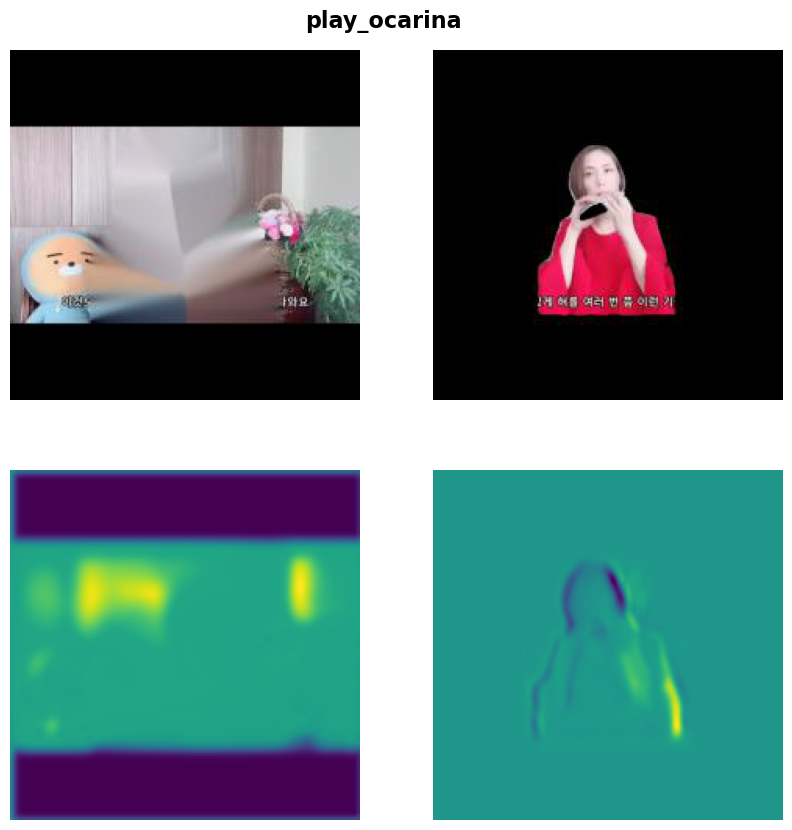

In [45]:
frames_idx = np.random.randint(low=0,high=test_data_frames_bg.shape[0])
flows_idx = np.floor((frames_idx/11*10)).astype(int)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1);plt.imshow(test_data_frames_bg[frames_idx,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float)[:,:,:]);plt.axis('off')
plt.subplot(2,2,2);plt.imshow(test_data_frames_seg[frames_idx,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float)[:,:,:]);plt.axis('off')
plt.subplot(2,2,3);plt.imshow(test_data_flows_bg[flows_idx,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float)[:,:,0]);plt.axis('off')
plt.subplot(2,2,4);plt.imshow(test_data_flows_seg[flows_idx,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float)[:,:,0]);plt.axis('off')
plt.suptitle(folders[test_labels_flows_bg[flows_idx]],y=.92,fontsize=16,fontweight='bold')

In [46]:
batch_size = 32
test_chunks = list(divide_chunks(np.arange(len(test_data_frames_bg)),batch_size))
n = len(test_chunks)-1


all_outputs_frames_bg = np.zeros((n*batch_size,121))
all_outputs_frames_seg = np.zeros((n*batch_size,121))
all_outputs_flows_bg = np.zeros((n*batch_size,121))
all_outputs_flows_seg = np.zeros((n*batch_size,121))
all_outputs_combined = np.zeros((n*batch_size,121))
all_lbls_frames = np.zeros(n*batch_size)
all_lbls_flows = np.zeros(n*batch_size)

for i in tqdm(range(n)):
    test_chunk = test_chunks[i]
    idx = np.arange(i*batch_size,i*batch_size+batch_size)
    
    frames_idx = test_chunk
    flows_idx = np.floor((frames_idx/11*10)).astype(int)
    
    lbls_frames = frames_lbls_vec[frames_idx]
    lbls_flows = test_labels_flows_seg[flows_idx]
    
    batch_frames_bg = test_data_frames_bg[frames_idx,:,:,:]
    batch_frames_seg = test_data_frames_seg[frames_idx,:,:,:]
    batch_flows_bg = test_data_flows_bg[flows_idx,:,:,:]
    batch_flows_seg = test_data_flows_seg[flows_idx,:,:,:]

    batch_frames_bg = torch.from_numpy(batch_frames_bg).half()
    batch_frames_seg = torch.from_numpy(batch_frames_seg).half()
    batch_flows_bg = torch.from_numpy(batch_flows_bg).half()
    batch_flows_seg = torch.from_numpy(batch_flows_seg).half()
    
    batch_frames_bg = batch_frames_bg.cuda()
    batch_frames_seg = batch_frames_seg.cuda()
    batch_flows_bg = batch_flows_bg.cuda()
    batch_flows_seg = batch_flows_seg.cuda()
    
    out_frames_bg,out_frames_seg,out_flows_bg,out_flows_seg,out_combined = combinedNet(batch_frames_bg,batch_frames_seg,batch_flows_bg,batch_flows_seg)

    all_outputs_frames_bg[idx,:] = out_frames_bg.detach().cpu().numpy()
    all_outputs_frames_seg[idx,:] = out_frames_seg.detach().cpu().numpy()
    all_outputs_flows_bg[idx,:] = out_flows_bg.detach().cpu().numpy()
    all_outputs_flows_seg[idx,:] = out_flows_seg.detach().cpu().numpy()
    all_outputs_combined[idx,:] = out_combined.detach().cpu().numpy()
    all_lbls_frames[idx] = lbls_frames
    all_lbls_flows[idx] = lbls_flows


100%|█████████████████████████████████████████| 240/240 [00:17<00:00, 14.11it/s]


In [47]:
all_outputs_frames_bg.shape

(7680, 121)

In [50]:
test_lbls = all_lbls_frames

[0.05455729166666667, 0.13502604166666668, 0.02578125, 0.19348958333333333, 0.24895833333333334]
[0.19440104166666666, 0.4322916666666667, 0.10729166666666666, 0.45924479166666665, 0.52890625]


Text(0.5, 0.98, '4-Stream DomainNet: test accuracy')

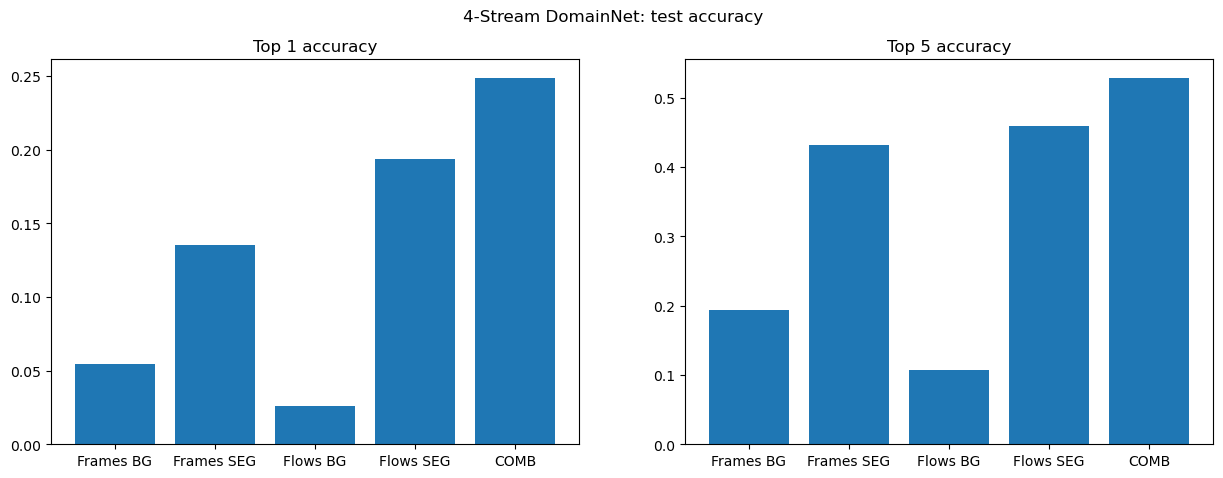

In [144]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

top1_acc_frames_bg = (all_outputs_frames_bg.argmax(axis=1)==test_lbls).mean()
top1_acc_frames_seg = (all_outputs_frames_seg.argmax(axis=1)==test_lbls).mean()
top1_acc_flows_bg = (all_outputs_flows_bg.argmax(axis=1)==test_lbls).mean()
top1_acc_flows_seg = (all_outputs_flows_seg.argmax(axis=1)==test_lbls).mean()
top1_acc_comb = (all_outputs_combined.argmax(axis=1)==test_lbls).mean()

ys = [top1_acc_frames_bg,top1_acc_frames_seg,top1_acc_flows_bg,top1_acc_flows_seg,top1_acc_comb]
ys_frames_top1 = ys.copy()
print(ys)
#ys = np.array(ys)-1/121
xs = np.arange(len(ys))
plt.bar(xs,ys)
lbls = ['Frames BG','Frames SEG','Flows BG','Flows SEG','COMB'];
plt.xticks(xs,labels=lbls);
plt.title('Top 1 accuracy')

plt.subplot(1,2,2)

top = 5
top5_acc_frames_bg = np.array([test_lbls[i] in np.argsort(all_outputs_frames_bg[i,:])[-1::-1][0:top] for i in range(len(test_lbls))]).mean()
top5_acc_frames_seg = np.array([test_lbls[i] in np.argsort(all_outputs_frames_seg[i,:])[-1::-1][0:top] for i in range(len(test_lbls))]).mean()
top5_acc_flows_bg = np.array([test_lbls[i] in np.argsort(all_outputs_flows_bg[i,:])[-1::-1][0:top] for i in range(len(test_lbls))]).mean()
top5_acc_flows_seg = np.array([test_lbls[i] in np.argsort(all_outputs_flows_seg[i,:])[-1::-1][0:top] for i in range(len(test_lbls))]).mean()
top5_acc_comb = np.array([test_lbls[i] in np.argsort(all_outputs_combined[i,:])[-1::-1][0:top] for i in range(len(test_lbls))]).mean()

ys = [top5_acc_frames_bg,top5_acc_frames_seg,top5_acc_flows_bg,top5_acc_flows_seg,top5_acc_comb];
ys_frames_top5 = ys.copy()
print(ys)
#ys = np.array(ys)-1/121*top
xs = np.arange(len(ys));
plt.bar(xs,ys);
lbls = ['Frames BG','Frames SEG','Flows BG','Flows SEG','COMB'];
plt.xticks(xs,labels=lbls);
plt.title('Top 5 accuracy')

plt.suptitle('4-Stream DomainNet: test accuracy')

In [130]:
vid_outputs_frames_bg = np.array([all_outputs_frames_bg[test_lbls==i,:].mean(axis=0) for i in range(121)])
vid_outputs_frames_seg = np.array([all_outputs_frames_seg[test_lbls==i,:].mean(axis=0) for i in range(121)])
vid_outputs_flows_bg = np.array([all_outputs_flows_bg[test_lbls==i,:].mean(axis=0) for i in range(121)])
vid_outputs_flows_seg = np.array([all_outputs_flows_seg[test_lbls==i,:].mean(axis=0) for i in range(121)])
vid_outputs_combined = np.array([all_outputs_combined[test_lbls==i,:].mean(axis=0) for i in range(121)])

vid_acc_top1_frames_bg = (vid_outputs_frames_bg.argmax(axis=1)==np.arange(121)).mean()
vid_acc_top1_frames_seg = (vid_outputs_frames_seg.argmax(axis=1)==np.arange(121)).mean()
vid_acc_top1_flows_bg = (vid_outputs_flows_bg.argmax(axis=1)==np.arange(121)).mean()
vid_acc_top1_flows_seg = (vid_outputs_flows_seg.argmax(axis=1)==np.arange(121)).mean()
vid_acc_top1_combined = (vid_outputs_combined.argmax(axis=1)==np.arange(121)).mean()


vid_acc_top5_frames_bg = np.array([i in np.argsort(vid_outputs_frames_bg[i,:])[-1::-1][0:5] for i in np.arange(121)]).mean()
vid_acc_top5_frames_seg = np.array([i in np.argsort(vid_outputs_frames_seg[i,:])[-1::-1][0:5] for i in np.arange(121)]).mean()
vid_acc_top5_flows_bg = np.array([i in np.argsort(vid_outputs_flows_bg[i,:])[-1::-1][0:5] for i in np.arange(121)]).mean()
vid_acc_top5_flows_seg = np.array([i in np.argsort(vid_outputs_flows_seg[i,:])[-1::-1][0:5] for i in np.arange(121)]).mean()
vid_acc_top5_combined = np.array([i in np.argsort(vid_outputs_combined[i,:])[-1::-1][0:5] for i in np.arange(121)]).mean()


[0.06611570247933884, 0.1487603305785124, 0.03305785123966942, 0.23140495867768596, 0.2644628099173554]
[0.1652892561983471, 0.4132231404958678, 0.12396694214876033, 0.512396694214876, 0.5537190082644629]


Text(0.5, 0.98, 'DomainNet Accuracy\nVid. Frame. Avg.')

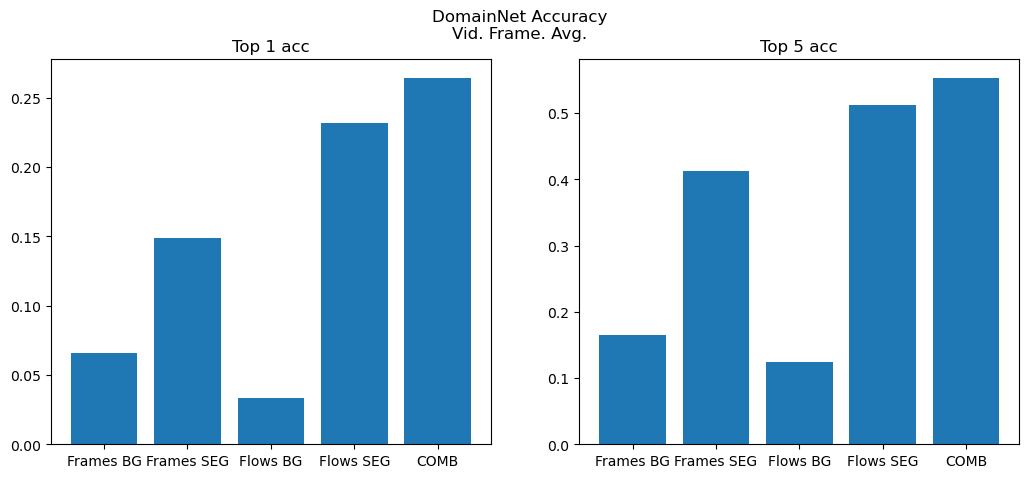

In [146]:
plt.figure(figsize=(12.5,5))
plt.subplot(1,2,1)
ys = [vid_acc_top1_frames_bg,vid_acc_top1_frames_seg,vid_acc_top1_flows_bg,vid_acc_top1_flows_seg,vid_acc_top1_combined]
ys_vid_top1 = ys.copy()
print(ys)
xs = np.arange(len(ys));
plt.bar(xs,ys);
lbls = ['Frames BG','Frames SEG','Flows BG','Flows SEG','COMB'];
plt.xticks(xs,labels=lbls);
plt.title('Top 1 acc')

plt.subplot(1,2,2)
ys = [vid_acc_top5_frames_bg,vid_acc_top5_frames_seg,vid_acc_top5_flows_bg,vid_acc_top5_flows_seg,vid_acc_top5_combined]
ys_vid_top5 = ys.copy()
print(ys)
xs = np.arange(len(ys));
plt.bar(xs,ys);
lbls = ['Frames BG','Frames SEG','Flows BG','Flows SEG','COMB'];
plt.xticks(xs,labels=lbls);
plt.title('Top 5 acc')

plt.suptitle('DomainNet Accuracy\nVid. Frame. Avg.')